In [ ]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def cargar_datos():
    base_path = "/content/drive/MyDrive/TFM/"
    rutas = {
        "pobreza": base_path + "Tasa de riesgo de pobreza por régimen de tenencia de la vivienda/fact/fact_tasa_riesgo_pobreza.csv",
        "regimen": base_path + "Tasa de riesgo de pobreza por régimen de tenencia de la vivienda/dims/dim_regimen_vivienda_riesgo.csv",
        "decil": base_path + "Personas por decil de renta por unidad de consumo y régimen de tenencia de la vivienda/fact/fact_personas_decil_renta.csv",
        "tamanohogar": base_path + "Renta por persona y unidad de consumo por tamaño de hogar/fact/fact_personas_renta_tamanohogar.csv",
        "tenencia": base_path + "Renta por persona y unidad consumo por régimen de tenencia de la vivienda/fact/fact_personas_renta_tenencia.csv",
        "urbanizacion": base_path + "Renta por persona y unidad consumo por grado de urbanización/fact/fact_renta_urbanizacion.csv"
    }
    data = {k: pd.read_csv(v) for k, v in rutas.items()}
    for df in data.values():
        df.rename(columns={'Anyo': 'Año'}, inplace=True)
    return data

In [ ]:
def preparar_datos(data):
    df = data["pobreza"].merge(data["regimen"], on="id_regimen_vivienda_riesgo", how="left")
    df = df.merge(data["decil"].groupby("Año")["Valor"].mean().reset_index().rename(columns={"Valor": "Renta_Decil_Media"}), on="Año")
    df = df.merge(data["tamanohogar"].groupby("Año")["Valor"].mean().reset_index().rename(columns={"Valor": "Renta_TamanoHogar_Media"}), on="Año")
    df = df.merge(data["tenencia"].groupby("Año")["Valor"].mean().reset_index().rename(columns={"Valor": "Renta_Tenencia_Media"}), on="Año")
    df = df.merge(data["urbanizacion"].groupby("Año")["Valor"].mean().reset_index().rename(columns={"Valor": "Renta_Urbanizacion_Media"}), on="Año")
    return df[df["Regimen_Vivienda"] != "Total"]

In [ ]:
def entrenar_y_evaluar_modelo(df, modelo):
    df_model = df[["Valor", "Regimen_Vivienda", "Año", "Renta_Decil_Media", "Renta_TamanoHogar_Media", "Renta_Tenencia_Media", "Renta_Urbanizacion_Media"]].copy()
    df_model = pd.get_dummies(df_model, columns=["Regimen_Vivienda"], drop_first=True)

    X = df_model.drop(columns=["Valor"])
    y = df_model["Valor"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return modelo, X, r2, mae

In [ ]:
# Analizamos los resultados utilizando las funciones
datos = cargar_datos()
df = preparar_datos(datos)

modelo_lr = LinearRegression()
modelo_lr, _, r2_lr, mae_lr = entrenar_y_evaluar_modelo(df, modelo_lr)

print("Evaluación del modelo de regresión lineal:")
print(f"R²: {r2_lr:.4f}")
print(f"MAE: {mae_lr:.2f}")

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf, X_rf, r2_rf, mae_rf = entrenar_y_evaluar_modelo(df, modelo_rf)

print("\nEvaluación del modelo Random Forest:")
print(f"R²: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.2f}")

Evaluación del modelo de regresión lineal:
R²: 0.9253
MAE: 3.52

Evaluación del modelo Random Forest:
R²: 0.8955
MAE: 4.20


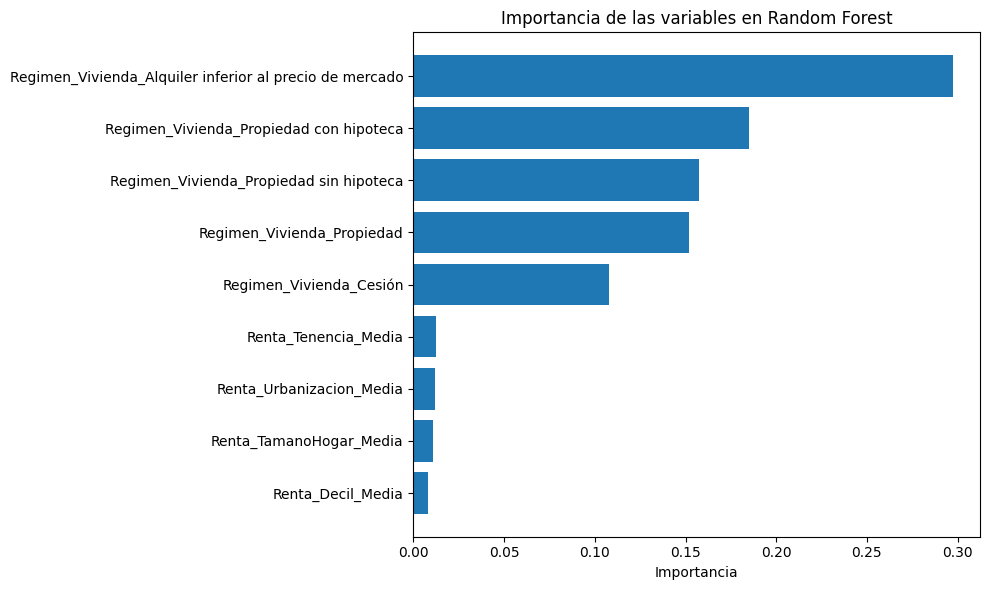

In [ ]:
# Importancia de las variables en RF
importancias = modelo_rf.feature_importances_
df_importancia = pd.DataFrame({'Variable': X_rf.columns, 'Importancia': importancias})
df_importancia = df_importancia[df_importancia['Variable'] != 'Año']
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(df_importancia['Variable'], df_importancia['Importancia'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de las variables en Random Forest')
plt.tight_layout()
plt.show()

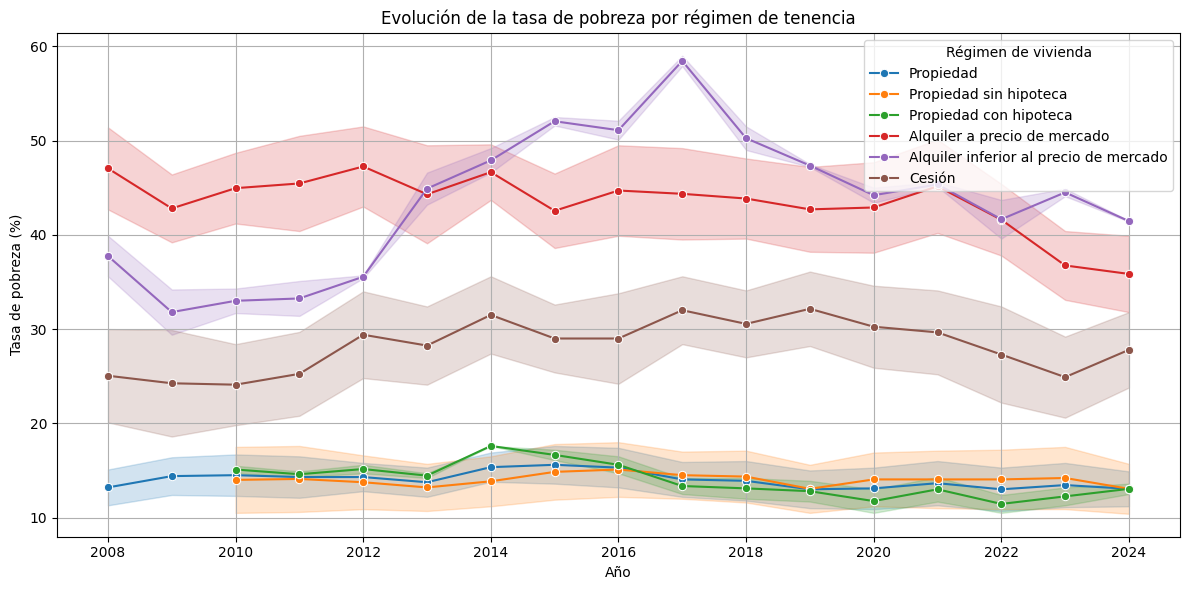

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Año', y='Valor', hue='Regimen_Vivienda', marker='o')
plt.title('Evolución de la tasa de pobreza por régimen de tenencia')
plt.ylabel('Tasa de pobreza (%)')
plt.xlabel('Año')
plt.grid(True)
plt.legend(title='Régimen de vivienda')
plt.tight_layout()
plt.show()

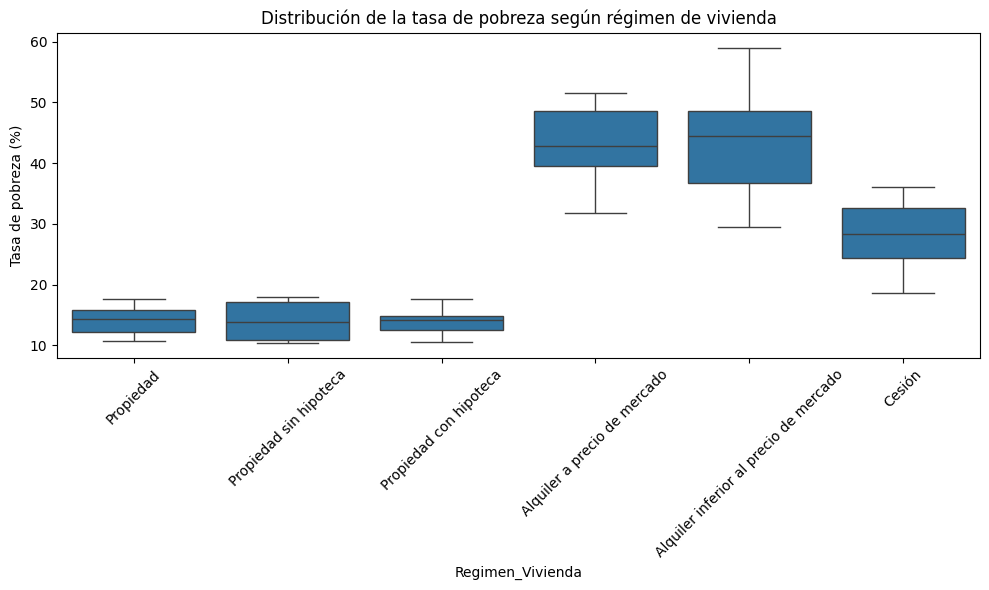

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Regimen_Vivienda', y='Valor')
plt.title('Distribución de la tasa de pobreza según régimen de vivienda')
plt.ylabel('Tasa de pobreza (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmponmdx_jv/7i1l49xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponmdx_jv/yw8wx__s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78654', 'data', 'file=/tmp/tmponmdx_jv/7i1l49xl.json', 'init=/tmp/tmponmdx_jv/yw8wx__s.json', 'output', 'file=/tmp/tmponmdx_jv/prophet_modell5ciojik/prophet_model-20250517144819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:48:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmponmdx_jv/xkkti9hw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmponmdx_jv/8yv53jb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

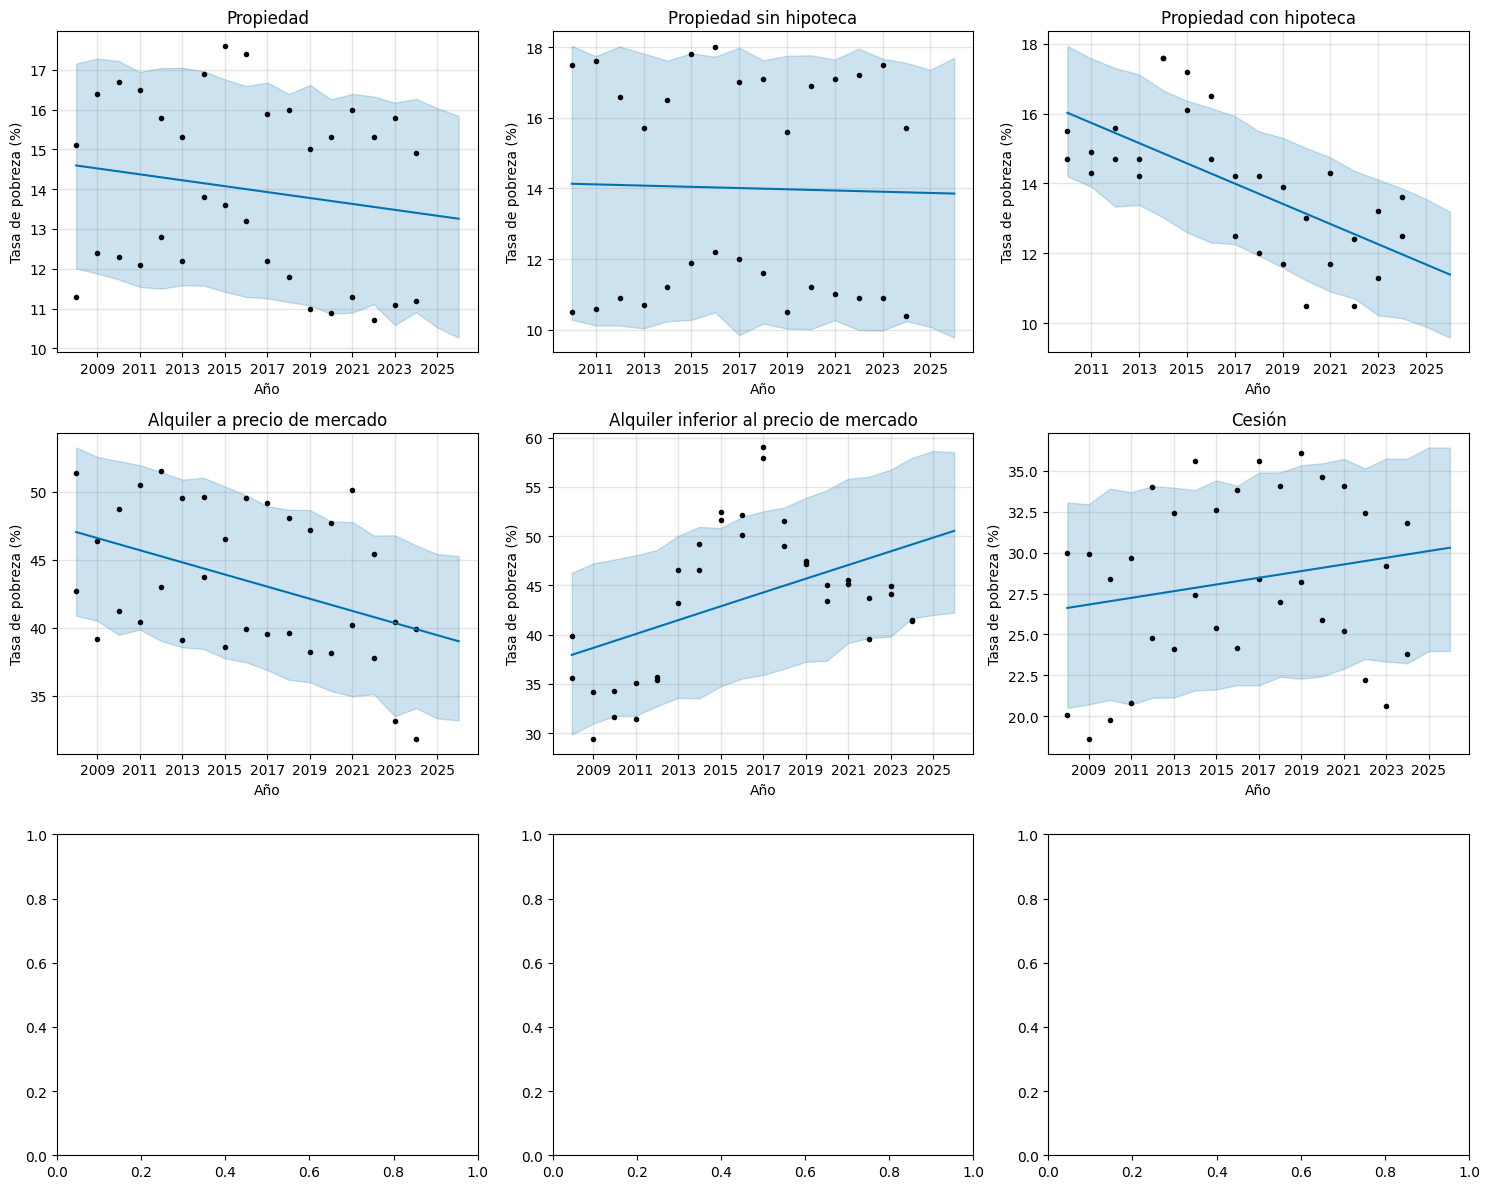


Propiedad
           ds       yhat
17 2024-12-31  13.331561
18 2025-12-31  13.257263

Propiedad sin hipoteca
           ds       yhat
15 2024-12-31  13.870765
16 2025-12-31  13.853447

Propiedad con hipoteca
           ds       yhat
15 2024-12-31  11.681952
16 2025-12-31  11.392735

Alquiler a precio de mercado
           ds       yhat
17 2024-12-31  39.445081
18 2025-12-31  38.999120

Alquiler inferior al precio de mercado
           ds       yhat
17 2024-12-31  49.842911
18 2025-12-31  50.537769

Cesión
           ds       yhat
17 2024-12-31  30.094746
18 2025-12-31  30.299060


In [ ]:
df_prophet = df[['Año', 'Valor', 'Regimen_Vivienda']].copy()
regimenes = df_prophet['Regimen_Vivienda'].unique()

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()
resultados = {}

for i, regimen in enumerate(regimenes):
    df_reg = df_prophet[df_prophet['Regimen_Vivienda'] == regimen][['Año', 'Valor']]
    df_reg = df_reg.rename(columns={'Año': 'ds', 'Valor': 'y'})
    df_reg['ds'] = pd.to_datetime(df_reg['ds'], format='%Y')

    modelo_p = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    modelo_p.fit(df_reg)

    futuro = modelo_p.make_future_dataframe(periods=2, freq='Y')
    forecast = modelo_p.predict(futuro)

    resultados[regimen] = forecast[['ds', 'yhat']].tail(2)
    modelo_p.plot(forecast, ax=axs[i])
    axs[i].set_xlabel("Año")
    axs[i].set_ylabel("Tasa de pobreza (%)")
    axs[i].set_title(regimen)

plt.tight_layout()
plt.show()

for regimen, forecast in resultados.items():
    print(f"\n{regimen}")
    print(forecast[['ds', 'yhat']])